# Initialize

In [1]:
from ops.imports_ipython import *
import glob

In [ ]:
os.chdir('20200206_6W-LaC025B/')

# combine tables

In [4]:
ops.utils.combine_tables('cp_phenotype',output_filetype='hdf',subdir='process_ph/tables',n_jobs=-2,
    usecols=[
        'well','tile','cell',
        'i','j','bounds_0','bounds_1','bounds_2','bounds_3',
        # to identify cells on an acquisition border
        'cell_dapi_min','cell_tubulin_min','cell_gh2ax_min','cell_phalloidin_min'
        ]
)
os.rename('cp_phenotype.hdf','min_cp_phenotype.hdf')

In [5]:
ops.utils.combine_tables('merge',output_filetype='hdf',subdir='alignment',n_jobs=-2)

In [ ]:
ops.utils.combine_tables('cells',output_filetype='hdf',subdir='process_sbs/tables',n_jobs=-2)

In [7]:
df_merged = pd.read_hdf('merge.hdf')

# add distance to FOV center for each cell

In [8]:
def fov_distance(df,i='i',j='j',dimensions=(2960,2960),suffix=''):
    distance  = lambda x: np.sqrt((x[i]-(dimensions[0]/2))**2+(x[j]-(dimensions[1]/2))**2)
    df['fov_distance'+suffix]=df.apply(distance,axis=1)
    return df

In [9]:
df_merged.pipe(fov_distance,i='i_0',j='j_0',suffix='_0');

In [10]:
df_merged.pipe(fov_distance,i='i_1',j='j_1',dimensions=(1480,1480),suffix='_1');

In [11]:
df_merged.sort_values(['fov_distance_1']).head()

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1
740,B2,342,767,1482.901757,1423.120364,94,2819,740.293478,740.250000,0.509454,56.953605,0.385525
527,B3,399,547,1481.961259,1460.223366,104,2094,739.383838,739.636364,0.215850,19.873646,0.715462
520,A2,1098,551,1524.695728,1451.782914,284,2266,739.553571,740.580357,0.158697,52.857470,0.732197
600,B3,1152,623,1531.504400,1470.868537,300,2360,740.226087,739.182609,0.129945,52.307618,0.848082
596,A3,493,620,1494.085202,1428.413837,132,2379,740.148515,740.900990,0.249477,53.474528,0.913148


# add mapping info

In [12]:
df_cells = pd.read_hdf('cells.hdf')

In [13]:
df_cells.head()

,cell,tile,well,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,...,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,barcode_count,sgRNA_0,gene_symbol_0,group_0,sgRNA_1,gene_symbol_1,group_1
0,39,166,B3,1.000000,0.603699,0.741508,0.542767,0.620503,0.580547,1.000000,...,1,NaN,0.0,1,ACGATCGGTAATGGTCTGTT,nontargeting,essentials_11L2,NaN,NaN,NaN
1,40,166,B3,0.017423,1.000000,0.258728,0.600712,1.000000,0.606609,0.858215,...,1,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,41,166,B3,0.565950,1.000000,1.000000,1.000000,0.641829,0.575390,0.625679,...,1,NaN,0.0,1,CTAACGGACTGCAGAACGGA,nontargeting,essentials_11L2,NaN,NaN,NaN
3,44,166,B3,0.450070,0.548385,0.542662,0.451723,1.000000,0.721898,0.701255,...,2,NaN,0.0,2,GCTTCACATGCATACCATGG,PPAN,essentials_11L2,NaN,NaN,NaN
4,45,166,B3,0.855391,0.566339,0.851803,0.139381,0.209817,0.009590,0.591237,...,1,GAAATACCACC,1.0,2,GAAATACGACCCCACCATCG,RAP2A,essentials_11L2,NaN,NaN,NaN


In [14]:
df_cells['mapped_single_gene'] = (df_cells.apply(lambda x: True 
                    if (pd.notnull(x.gene_symbol_0)&pd.isnull(x.gene_symbol_1))|(x.gene_symbol_0==x.gene_symbol_1) 
                    else False,axis=1)
                                  )

In [15]:
df_cells.mapped_single_gene.value_counts()

True     5189121
False    2756241
Name: mapped_single_gene, dtype: int64

In [16]:
df_merged = df_merged.merge((df_cells[['well','tile','cell','sgRNA_0','gene_symbol_0','group_0','mapped_single_gene']]
                             .rename({'tile':'site','cell':'cell_1'},axis=1)),
                            how='left',on=['well','site','cell_1'])

In [17]:
df_merged.head(10).sort_values(['mapped_single_gene','fov_distance_1'],ascending=[False,True])

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,group_0,mapped_single_gene
2,B3,474,422,1081.831585,1346.047203,123,10,3.406593,703.692308,0.899929,420.096939,737.487692,NaN,NaN,NaN,NaN
1,B3,474,419,1079.878977,1044.191516,123,9,3.375000,628.375000,0.519400,591.629840,745.034584,NaN,NaN,NaN,NaN
3,B3,474,414,1066.679772,2042.936588,123,12,1.547619,878.833333,1.650511,698.377558,751.389788,NaN,NaN,NaN,NaN
9,B3,474,425,1089.951432,726.879826,123,26,4.906977,548.860465,1.187036,848.131996,759.536750,NaN,NaN,NaN,NaN
4,B3,474,415,1068.747573,2412.256425,123,14,1.538462,971.653846,1.170977,1018.936014,773.943763,NaN,NaN,NaN,NaN
5,B3,474,421,1080.817849,2481.269934,123,15,3.393443,989.540984,0.741017,1077.909027,777.727409,NaN,NaN,NaN,NaN
7,B3,474,423,1082.552054,2521.753517,123,23,3.726190,1000.095238,1.161028,1114.995632,780.864044,NaN,NaN,NaN,NaN
6,B3,474,420,1080.136466,2687.760054,123,16,3.616162,1041.646465,1.205647,1272.232366,795.771165,NaN,NaN,NaN,NaN
8,B3,474,424,1083.538979,244.550196,123,24,4.150538,428.172043,0.524183,1297.504358,799.194035,NaN,NaN,NaN,NaN
0,B3,474,418,1071.756060,107.927798,123,6,2.367647,393.882353,1.053052,1431.518509,814.799923,NaN,NaN,NaN,NaN


# add phenotype min info

In [18]:
df_phenotype = pd.read_hdf('min_cp_phenotype.hdf').fillna(0)

In [19]:
min_cols = [col for col in df_phenotype.columns if '_min' in col]
info_cols = [col for col in df_phenotype.columns if col not in min_cols]

In [21]:
df_phenotype['channels_min'] = df_phenotype[min_cols].apply(lambda x: x.min(axis=0),axis=1)

In [23]:
df_merged = df_merged.merge((df_phenotype[['well','tile','cell','channels_min']]
                             .rename(columns={'cell':'cell_0'})),
                            how='left',on=['well','tile','cell_0'])

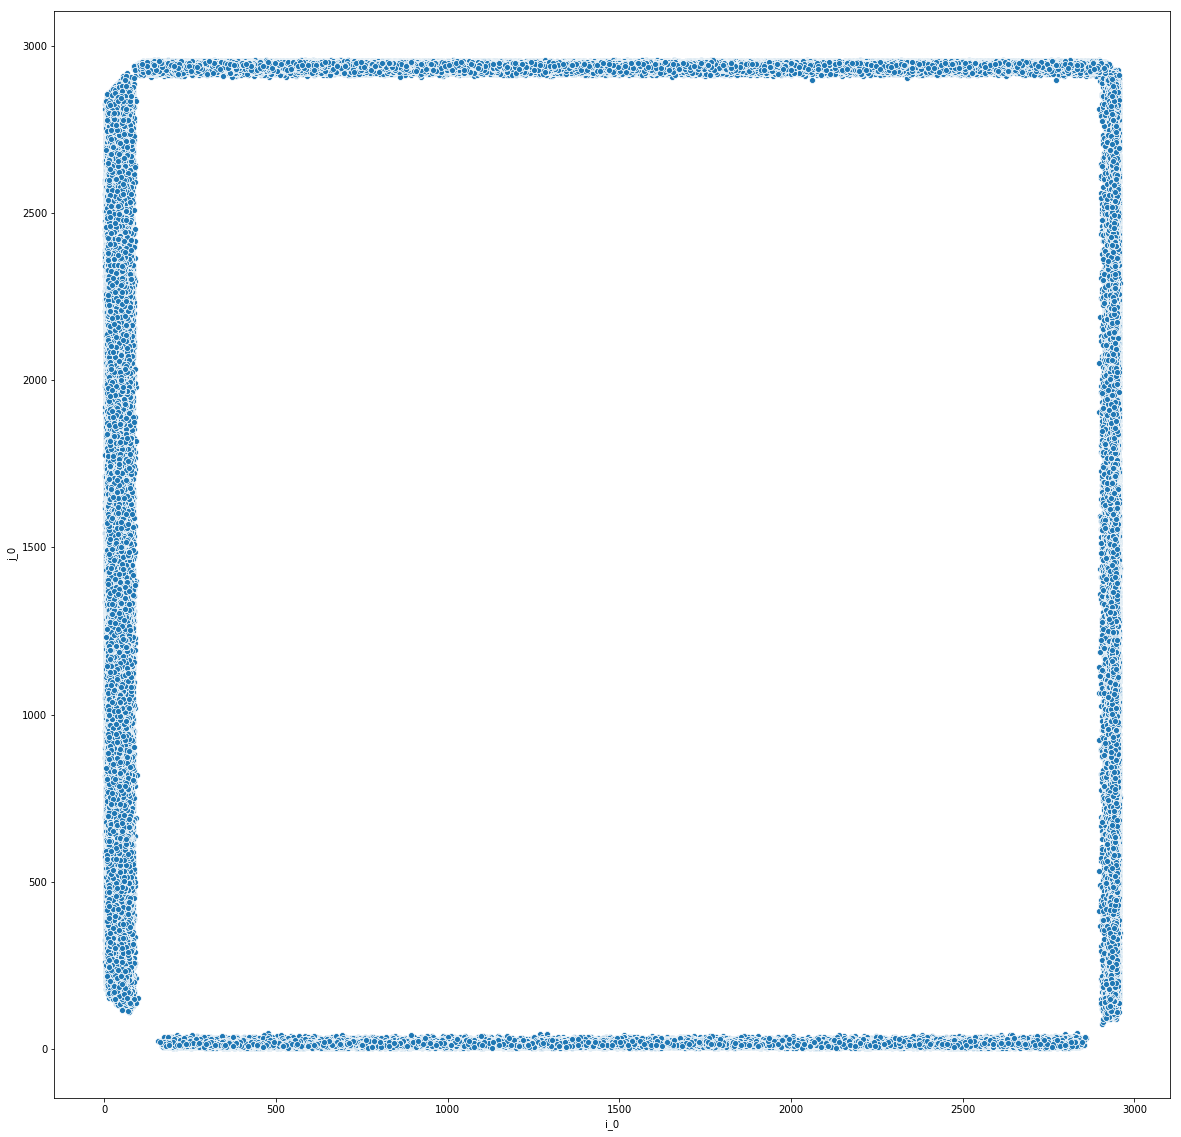

In [24]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=(df_merged
                      .query('channels_min==0')
#                       .query('well != @misaligned_wells & tile != @misaligned_tiles')
                      [['i_0','j_0']]
                     ),
                x='i_0',y='j_0')

# filter merged datasets for duplicates

In [5]:
df_merged.groupby(['well','tile']).cell_0.value_counts().value_counts()

1    6683560
2    1986386
3      34992
4       2035
Name: cell_0, dtype: int64

In [6]:
df_merged.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6507641
2    1997146
3      63101
4      19553
Name: cell_1, dtype: int64

In [7]:
df_merged.drop_duplicates(['well','site','cell_1']).pipe(len)

8587441

In [8]:
df_merged.pipe(len)

10769448

In [10]:
# remove bad tiles and cells with phenotype channel min ==0
df_merged_ph = (df_merged
#              .query('well != @misaligned_wells & tile != @misaligned_tiles')
             .query('channels_min>0')
            )

In [11]:
df_merged_ph.drop_duplicates(['well','site','cell_1']).pipe(len)

8563863

In [12]:
df_merged_ph.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6806544
2    1707129
3      39142
4      11048
Name: cell_1, dtype: int64

In [13]:
# drop sbs cells mapping to same phenotype cell by priority (mapping, fov_distance)
df_merged_filt = (df_merged_ph
                  .sort_values(['mapped_single_gene','fov_distance_1'],
                               ascending=[False,True])
                  .drop_duplicates(['well','tile','cell_0'],keep='first')
                 )

In [14]:
df_merged_filt.groupby(['well','site']).cell_1.value_counts().value_counts()

1    5262894
2    1467275
3      39142
4      11048
Name: cell_1, dtype: int64

In [15]:
# drop duplicated phenotype cells mapping to same sbs cell by priority (fov_distance)
df_merged_filt_filt = (df_merged_filt
                       .sort_values(['fov_distance_0'],ascending=True)
                       .drop_duplicates(['well','site','cell_1'],keep='first')
                      )

In [16]:
df_merged_filt_filt.pipe(len)

6780359

In [17]:
df_merged_filt_filt[df_merged_filt_filt.mapped_single_gene==True].pipe(len)

3894472

In [ ]:
df_merged.to_hdf('merge.hdf', 'x', mode='w')

In [ ]:
df_merged_filt_filt.to_hdf('merged_deduped.hdf', 'x', mode='w')

# check cell matching rate

In [23]:
df_sbs_info = pd.concat([pd.read_hdf(f) for f in glob.glob('sbs_info_*.hdf')])

In [24]:
df_sbs_info.to_hdf('sbs_info.hdf','x',mode='w')

In [25]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_1','tile':'site'}

#before deduping, how many sbs cells map to a phenotype cell
df_sbs_matching = (df_sbs_info
                   .rename(columns=cols_1)
                   .drop(columns=['i','j'])
                   .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','site','cell_1'])
                  )

In [26]:
# before deduping
for well,df in df_sbs_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 89.35111991790808%
For well A2, cell matching rate is 90.38442373050272%
For well A3, cell matching rate is 90.23644656060277%
For well B1, cell matching rate is 90.1759786649547%
For well B2, cell matching rate is 90.53280207986447%
For well B3, cell matching rate is 90.1820673245451%


In [27]:
del df_sbs_matching

In [28]:
del df_sbs_info

In [29]:
df_ph_info = pd.concat([pd.read_hdf(f) for f in glob.glob('ph_info_*.hdf')])

In [30]:
df_ph_info.to_hdf('ph_info.hdf','x',mode='w')

In [31]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_0'}

#before deduping, how many sbs cells map to a phenotype cell
df_ph_matching = (df_ph_info
                 .rename(columns=cols_1)
                 .drop(columns=['i','j'])
                 .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','tile','cell_0'])
                )

In [32]:
for well,df in df_ph_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 92.10451062439087%
For well A2, cell matching rate is 93.13707357226055%
For well A3, cell matching rate is 92.76247440427404%
For well B1, cell matching rate is 92.80080472270437%
For well B2, cell matching rate is 92.64175283286488%
For well B3, cell matching rate is 92.10426107361653%


# add full phenotype, reduce to single mapping

In [ ]:
# this section unused?

In [33]:
import gc

In [34]:
df_merged_deduped = pd.read_hdf('merged_deduped.hdf')

In [35]:
df_merged_deduped = df_merged_deduped[df_merged_deduped['mapped_single_gene']==True]

In [36]:
df_merged_deduped.pipe(len)

3894472

In [37]:
df_phenotype = pd.read_hdf('simple_nuclear_phenotype.hdf')

In [38]:
gc.collect()

243

In [39]:
final_merge_cols = [col for col in df_merged_deduped.columns 
                    if 'distance' not in col 
                        and col != 'mapped_single_gene' 
                        and col != 'channels_min'
                   ]

In [40]:
final_merge_cols

['well',
 'tile',
 'cell_0',
 'i_0',
 'j_0',
 'site',
 'cell_1',
 'i_1',
 'j_1',
 'sgRNA_0',
 'gene_symbol_0',
 'group_0']

In [41]:
df_merged_deduped = df_merged_deduped[final_merge_cols]

In [42]:
final_ph_cols = [col for col in df_phenotype.columns 
                    if col not in ['i','j']
                   ]

In [43]:
df_phenotype = df_phenotype[final_ph_cols].rename(columns={'cell':'cell_0'})

In [44]:
df_phenotype.head()

,dapi_nuclear_min,dapi_nuclear_25,dapi_nuclear_mean,dapi_nuclear_median,dapi_nuclear_75,dapi_nuclear_max,dapi_nuclear_int,dapi_nuclear_sd,dapi_nuclear_mad,dm1a_nuclear_min,...,solidity_nuclear,extent_nuclear,area,cell_0,bounds_0,bounds_1,bounds_2,bounds_3,tile,well
0,513,898.00,1086.529316,1107.5,1289.50,1621,667129,251.818937,190.5,0,...,0.910979,0.702517,614,1,0,345,19,391,115,B3
1,1025,1377.00,1729.268775,1732.0,2053.00,2623,437505,418.234988,344.0,0,...,0.916667,0.602381,253,2,0,561,14,591,115,B3
2,770,1395.25,1919.731250,2146.5,2383.00,2813,1228628,562.127871,328.0,0,...,0.931587,0.680851,640,3,0,689,20,736,115,B3
3,1545,2639.75,5845.984029,3786.0,7984.00,17056,4758631,4387.534707,1578.5,0,...,0.939954,0.753704,814,4,0,779,20,833,115,B3
4,742,973.75,1679.296923,1324.0,2461.75,3475,1091543,802.661846,459.0,0,...,0.947522,0.681342,650,5,0,1058,18,1111,115,B3


In [45]:
df_merged_deduped_phenotype = df_merged_deduped.merge(df_phenotype,how='left',on=['well','tile','cell_0'])

In [46]:
df_merged_deduped_phenotype.pipe(len)

3894472

In [47]:
def remove_edge_cells(df):
    df['edge'] = df[['bounds_0','bounds_1','bounds_2','bounds_3']].apply(lambda x:( x.min(axis=0)==0)|(x.max(axis=0)==2960),axis=1)
    return df[df['edge'] != True].drop(columns='edge')


In [48]:
gb_cols = ['well','tile']

In [49]:
df_merged_deduped_phenotype = df_merged_deduped_phenotype.pipe(ops.utils.gb_apply_parallel,gb_cols,remove_edge_cells,n_jobs=-1)

In [50]:
df_merged_deduped_phenotype.pipe(len)

3893244

In [51]:
df_merged_deduped_phenotype.to_hdf('merged_deduped_phenotype.hdf','x',mode='w')

In [52]:
df_merged_deduped_phenotype.columns

Index(['well', 'tile', 'cell_0', 'i_0', 'j_0', 'site', 'cell_1', 'i_1', 'j_1',
       'sgRNA_0', 'gene_symbol_0', 'group_0', 'dapi_nuclear_min',
       'dapi_nuclear_25', 'dapi_nuclear_mean', 'dapi_nuclear_median',
       'dapi_nuclear_75', 'dapi_nuclear_max', 'dapi_nuclear_int',
       'dapi_nuclear_sd', 'dapi_nuclear_mad', 'dm1a_nuclear_min',
       'dm1a_nuclear_25', 'dm1a_nuclear_mean', 'dm1a_nuclear_median',
       'dm1a_nuclear_75', 'dm1a_nuclear_max', 'dm1a_nuclear_int',
       'dm1a_nuclear_sd', 'dm1a_nuclear_mad', 'gh2ax_nuclear_min',
       'gh2ax_nuclear_25', 'gh2ax_nuclear_mean', 'gh2ax_nuclear_median',
       'gh2ax_nuclear_75', 'gh2ax_nuclear_max', 'gh2ax_nuclear_int',
       'gh2ax_nuclear_sd', 'gh2ax_nuclear_mad', 'phalloidin_nuclear_min',
       'phalloidin_nuclear_25', 'phalloidin_nuclear_mean',
       'phalloidin_nuclear_median', 'phalloidin_nuclear_75',
       'phalloidin_nuclear_max', 'phalloidin_nuclear_int',
       'phalloidin_nuclear_sd', 'phalloidin_nuclear_mad